# Processing and filtering marker gene datasets

Here, we'll walk through some filtering strategies applicable to compositional marker gene studies. We will employ several custom R functions designed to manipulate phyloseq-class datasets that aid in the processing, filtering, and reproducability of marker gene studies. We apply this workflow to a moderately sized 16S community dataset generated on an Illumina HiSeq, though these strategies should be widely useful to any marker gene and easily scalable to large datasets with thousands of taxa and samples. _For reference, this entire notebook can be run in about 30 seconds on a 13" 2013 Macbook Pro._<br>
<br>
Briefly, the aims of this vignette and associated functions are to:<br>
1. Estimate and apply dataset-specific filtering parameters.<br>
2. Provide a set of robust and highly reproducible processing, filtering, and exporting functions for marker gene studies.<br>
3. Faciltate transparency and reproducability of marker gene data analysis, regardless of user skill level.<br>

<div class="alert alert-block alert-info">
<b>A preface on filtering:</b> Filtering is an <i>essential</i> step in the analyis of marker gene datasets. This workflow uses a two-pronged approach (within sample and across sample) to filtering contaminants from read datasets. That is, we attempt to remove two types of contamination: <br>
<br>
1. Real biological sequences that have cross contaminated unassociated samples. <br>
<br>
2. Exogenous contaminants introduced during sample preparation. <br>
<br>
To achieve this, we first estimate and apply <b>within-sample (WS)</b> filters to remove taxa below an abundance threshold individually within each sample. We estimate this threshold empirically by measuring the number of amplicon sequence variants (ASVs) within known mock communities under various thresholds and select the threshold that returns the appropriate ASV count. Next, we (optionally) remove control samples from the dataset and then apply several <b>across-sample (AS)</b> filters (relative abundance, prevalence, and/or coefficient of variation (CV)) to remove exogenous contaminants present as low abundance ASVs. 
</div>

***

## Jump to section:
[estimate.WSthreshold](#estimate.WSthreshold)<br>
[estimate.ASthreshold](#estimate.ASthreshold)<br>
[filter.dataset](#filter.dataset)<br>
[write.dataset](#write.dataset)


## Before we begin...
This workflow assumes that your sequencing project: 
-  has been converted into a __[phyloseq](https://joey711.github.io/phyloseq/)__ object.

and ideally:<br>
-  includes a mock community or other positive control of known composition. <br>
-  has been processed with __[dada2](https://benjjneb.github.io/dada2/index.html)__ (this is not necessary, but we leverage the output of dada2 to align control sequences and write filtered FASTA files).<br>
<br>
Now, let's load some required packages and begin!

In [1]:
suppressMessages(library(RCurl)); packageVersion("RCurl")

[1] ‘1.95.4.10’

In [2]:
library(phyloseq); packageVersion("phyloseq")

[1] ‘1.19.1’

In [3]:
suppressMessages(library(cowplot)); packageVersion("cowplot")

[1] ‘0.9.2’

In [4]:
library(ggplot2); packageVersion("ggplot2")
theme_set(theme_bw()) #gray is a bummer

[1] ‘2.2.1’

In [5]:
suppressMessages(library(tidyr)); packageVersion("tidyr")

[1] ‘0.8.1’

In [6]:
library(devtools); packageVersion("devtools")


[1] ‘1.13.6’

In [7]:
suppressMessages(library(ShortRead)); packageVersion("ShortRead")


[1] ‘1.32.1’

## Getting started
First, we'll need to source these functions into our R environment. We can do that directly from Github with some handy tools provided by HW. 

In [8]:
myfunctions <- "https://github.com/itsmisterbrown/marker_gene_processing_scripts/raw/master/marker_gene_processing_functions.R"
source_url(myfunctions) #compliments of Hadley

SHA-1 hash of file is 418450e427b6f3a3661153735841ebd5d7c7933e


Now, let's load the dataset and subset it to remove taxa not annotated at the Phylum level and identified as Chloroplast sequences.

In [9]:
#load the dataset
NI <- readRDS(file = "/Users/bpb/Desktop/marker_gene_filtering_functions/marker_gene_processing_vignette/NI.dada2.RDS")

NI %>%
  subset_taxa(Phylum != "NA" & 
                Phylum != "Cyanobacteria/Chloroplast") -> NI

table(tax_table(NI)[, "Phylum"], exclude = NULL)


              Acidobacteria              Actinobacteria 
                         22                         629 
            Armatimonadetes               Bacteroidetes 
                          6                         359 
   candidate_division_WPS-1 Candidatus_Saccharibacteria 
                          1                           6 
                Chloroflexi             Deferribacteres 
                         17                           1 
        Deinococcus-Thermus                  Firmicutes 
                         10                        1211 
               Fusobacteria            Gemmatimonadetes 
                         25                           1 
                Nitrospirae              Planctomycetes 
                          3                          59 
             Proteobacteria                Spirochaetes 
                        815                           3 
              Synergistetes                 Tenericutes 
                          1   

For this vignette, we'll work with a subset of a recent study of stool samples from Nigerian infants. Let's take a look at the raw dataset

In [10]:
NI

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3176 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 3176 taxa by 7 taxonomic ranks ]

Our unfiltered object has 3,176 taxa (that's a lot!), though some of those bugs are likely contaminants or irrelevent stochastic associates. We'll use some filtering functions to pare that number down to a smaller set of  bugs that we can interrogate with downstream analyses. <br>
<br>
## Filtering

The first step in our workflow is to estimate the threshold at which our data suggest cross contamination exists. Because cross contamination cannot be corrected with standard global filters, we need to estimate the extent of cross contamination and apply our filter individually within each sample. We estimate this filtering threshold against a known positive control library (HMP Mock; HM-782D) of 20 taxa using the __estimate.WSthreshold()__ function. However, due to operon variation along 16S, __we expect 23 unique ASVs along the region sequenced (V6)__. In addition to threshold estimation, __ws.threshold()__ also performs a local alignment of each ASV sequence within your postiive control against a fasta file to determine the number of exact matches between the actual composition of your sequenced control and its theoretical composition. <br>
<br>
__Note:__ sequence alignment is only supported for datasets processed by DADA2. DADA2 does not assign names to each ASV, but rather uses the nucleotide sequence as the identifier; we leverage this feature to perform sequence alignment and write output in FASTA format.
<br>

<a id="estimate.WSthreshold"></a>
# estimate.WSthreshold
<div class="alert alert-block alert-info">
<b>ESTIMATE.WSTHRESHOLD</b><br>
Performs WS filter threshold estiamtion by iterative application over a range of thresholds. <br>
<br>
<b>Input:</b> <br>
<b>ps:</b> a phyloseq-class dataset<br>
<br>
<b>Parameters:</b><br>
<b>WSrange:</b> The range of WS filter thresholds to iterate over, followed by the estimation interval.<br>
<b>controlID:</b> The sample ID of a positive control library, if applicable. Used for reporting ASV read count, taxonomy, and sequence alignment of taxa in the positive control.<br>
<b>controlFASTA:</b> the path to a FASTA file of nucleotide sequences to be used for alignment to positive control sequences, if applicable.<br>
<br>
<b>Output:</b> <br>
A dataframe of:<br>
<b>threshold.value:</b> The WS threshold applied in that iteration. <br>
<b>control.taxa.count:</b> The count of taxa in the given positive control. <br>
<b>control.taxa.matches:</b> The number of perfect alignments between taxa in the given control and the controlFASTA file. <br>
<b>read.count:</b> The read count in the positive control at the listed threshold value. <br>
<b>read.percent:</b> The read percent (vs. pre-filter read count) in the positive control at the listed threshold value. <br>

</div>

<br>
<div class="alert alert-block alert-success">
<b>TIP:</b> All of these functions support <b>vectorized input</b> for both convenience and ease of visualization! The format for the vectorized input used here is: <b>lower threshold:higher threshold, estimation interval</b>. For example, below, we will estimate over the range from 1e-5 to 2e-4 with an estimation interval of 1e-5.
</div>

In [11]:
#load a FASTA file of full length 16S sequences for each operon of each community member
mockf <- "/Users/bpb/Desktop/HMP_MOCK.v35.fasta"

(ws.threshold <- estimate.WSthreshold(ps = NI, WSrange = c(1e-5:2e-4, 1e-5), controlID = "pc1", controlFASTA = mockf))

Estimating filtering statistics from WS thresholds 1e-05 to 2e-04 by 1e-05


threshold.value,control.taxa.count,control.taxa.matches,read.count,read.percent
0.00001,36,23,92978550,99.98106
0.00002,35,23,92949748,99.95009
0.00003,30,22,92923580,99.92195
0.00004,30,22,92899476,99.89603
0.00005,28,22,92876359,99.87117
0.00006,27,22,92856037,99.84932
0.00007,27,22,92835116,99.82682
0.00008,26,22,92815880,99.80614
0.00009,25,22,92797926,99.78683
0.00010,25,22,92779812,99.76735


And let's take a peek at a quick visual summary

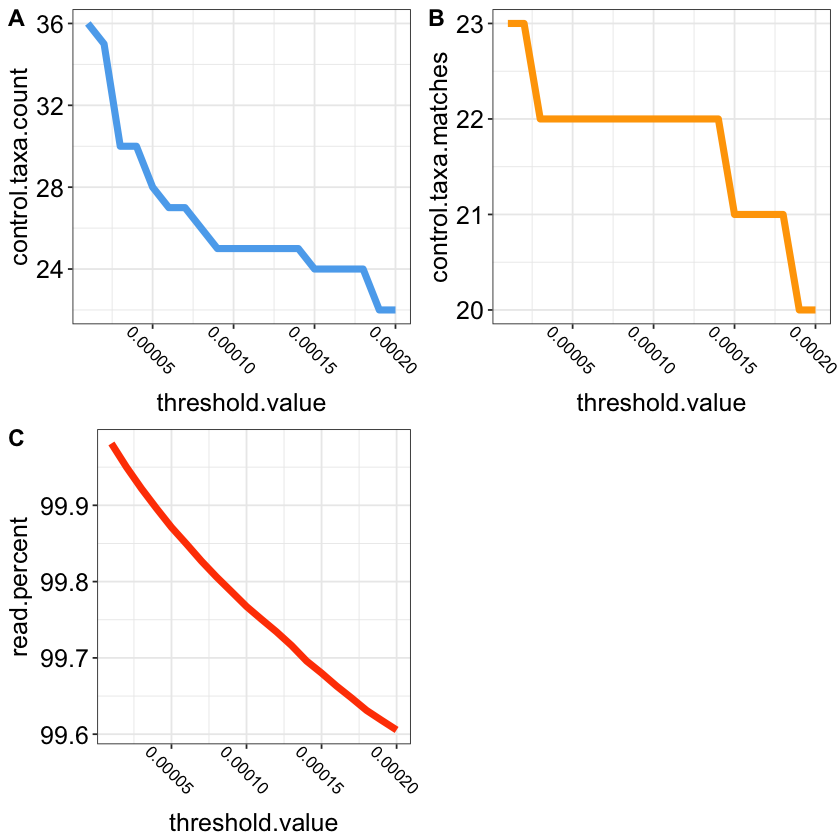

In [12]:
plot1 <- ggplot(data = ws.threshold, aes(x = threshold.value, y = control.taxa.count)) + geom_line(size=2, color="steelblue2") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 10, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black"))

plot2 <- ggplot(data = ws.threshold, aes(x = threshold.value, y = control.taxa.matches)) + geom_line(size=2, color="orange") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 10, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black"))

plot3 <- ggplot(data = ws.threshold, aes(x = threshold.value, y = read.percent)) + geom_line(size=2, color="orangered1") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 10, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black")) 

plot_grid(plot1, plot2, plot3, labels = "AUTO")



***
Though it's not a perfect match, we'll use a WS threshold of 1.4e-4, as it yields 22/23 mock community matches and significantly pares down contaminant ASVs without sacrificing too many reads. Now that we've determined our WS threshold, let's estimate our AS filter thresholds with this value as a fixed parameter. There are several global, AS filtering strategies for removing exogenous contaminants from marker gene datasets. Here, we focus on three popular approaches that can all be estimated and applied using the suite of functions sourced above. <br>
<br>

<a id="estimate.ASthreshold"></a>
# estimate.ASthreshold
<div class="alert alert-block alert-info">
<b>ESTIMATE.ASTHRESHOLD</b><br>
Performs AS filter threshold estiamtion by iterative application over a range of threshold values and filtering strategies. Supports the (optional) application of fixed thresholds if you want to optimize one or multiple threshold with the other(s) fixed. <br>
<br>
<b>Input:</b> <br>
<b>ps:</b> a phyloseq-class dataset.<br>
<br>
<b>Parameters (all are optional):</b><br>
<b>WST:</b> The WS threshold to apply before estimation of AS thresholds.<br>
<b>mdCAT:</b> The sample data category used in conjunction with mdFACTOR for metadata based filtering.<br>
<b>mdFACTOR:</b> The factor within mdCAT used for metadata based filtering.<br>
<b>mdNEGATIVE:</b> A logical flag indicating whether metadata-based filtering should be positive (remove matching samples) or negative (remove non matching samples).<br>
<b>minLIB:</b> The minimum sequence depth for a sample to be retained.<br>
<b>RArange:</b> The range of relative abundance filter thresholds to iterate over, followed by the estimation interval. <br>
<b>CVrange:</b> The range of CV filter thresholds to iterate over, followed by the estimation interval.<br>
<b>PFrange:</b> The range of prevalence filter thresholds to iterate over, followed by the estimation interval. <br>
<b>RAT:</b> Relative Abundance Threshold; the fixed percentage of reads across the dataset for which an ASV must be present for that ASV to be retained. <br>
<b>CVT:</b> Coefficient of Variation Threshold; the fixed lowest CV value of an ASV for that ASV to be retained.<br>
<b>PFT:</b> Prevalence Filter Threshold; the fixed percentage of samples across the dataset for which an ASV must be present for that ASV to be retained. <br>

<br>
<b>Output:</b> <br>
<b>relative.abundance.filtering.stats:</b> The ASV count remaining in the dataset at the given relative abundance threshold. <br>
<b>CV.filtering.stats:</b> The ASV count remaining in the dataset at the given CV threshold. <br>
<b>prevalence.filtering.stats:</b> The ASV count remaining in the dataset at the given prevalence threshold. <br>
<b>ASV.filtering.stats:</b> A dataframe listing the read count, read percent, prevalence count, prevalence percent, CV, taxonomic ranks, and sequence identity of each ASV.<br>

</div> 


We'll use the __estimate.ASthreshold()__ function to simultaneously estimate all three filter thresholds.

In [13]:
as.threshold <- estimate.ASthreshold(ps = NI, WST = 1.4e-4, minLIB = 4000, mdCAT = "timepoint", 
                                      mdFACTOR = "control", Prange = c(0.01:0.1, 0.005), CVrange = c(0:5, 0.1), 
                                      RArange = c(1e-7:1e-5, 1e-7))

Removing 13 samples with read count < 4000
Applying WS filter threshold of 0.00014
Removing 6 samples matching metadata identifiers timepoint:control
Estimating filtering statistics from relative abundance thresholds 1e-07 to 1e-05 by 1e-07
Estimating filtering statistics from CV thresholds 0 to 5 by 0.1
Estimating filtering statistics from prevalence thresholds 0.01 to 0.1 by 0.005


In [14]:
as.threshold$relative.abundance.filtering.stats[1:10,]

relative.abundance.filter,ASV.count
1e-07,887
2e-07,837
3e-07,794
4e-07,770
5e-07,761
6e-07,743
7e-07,732
8e-07,723
9e-07,708
1e-06,695


In [15]:
as.threshold$CV.filtering.stats[1:10,]

CV.filter,ASV.count
0.0,978
0.1,978
0.2,978
0.3,978
0.4,978
0.5,978
0.6,978
0.7,978
0.8,978
0.9,978


In [16]:
as.threshold$prevalence.filtering.stats[1:10,]

prevalence.filter,ASV.count
0.010,620
0.015,416
0.020,416
0.025,328
0.030,280
0.035,248
0.040,248
0.045,217
0.050,197
0.055,197


In [17]:
as.threshold$ASV.filtering.stats[1:10,]

ASV.read.count,ASV.read.percent,ASV.prevalence,ASV.prevalence.percent,ASV.CV,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASV.ID
16756456,18.075627,144,96.64430,1.337880,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,lactarius/salivarius,GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCCGATGCTATTTCTAGAGATAGGAAGTTACTTCGGTACATCGGTGACAGG
9524897,10.274755,145,97.31544,1.915157,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,NA,GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTTTGACCACTCTAGAGATAGAGCTTCCCCTTCGGGGGCAAAGTGACAGG
5018847,5.413961,139,93.28859,1.598313,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,breve/longum,GGGCCCGCACAAGCGGCGGAGCATGCGGATTAATTCGATGCAACGCGAAGAACCTTACCTGGGCTTGACATGTTCCCGACGATCCCAGAGATGGGGTTTCCCTTCGGGGCGGGTTCACAGGT
4489657,4.843110,121,81.20805,2.306163,Bacteria,Actinobacteria,Actinobacteria,Coriobacteriales,Coriobacteriaceae,Collinsella,aerofaciens,GGGCCCGCACAAGCAGCGGAGCATGTGGCTTAATTCGAAGCAACGCGAAGAACCTTACCAGGGCTTGACATATGGGTGAAGCGGGGGAGACCCCGTGGCCGAGAGGAGCCCATACAGGTGGT
3923735,4.232635,132,88.59060,2.912638,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Salmonella,NA,GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACAGAACTTTCCAGAGATGGATTGGTGCCTTCGGGAACTGTGAGACAGG
3708829,4.000811,131,87.91946,2.333284,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia/Shigella,NA,GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACGGAAGTTTTCAGAGATGAGAATGTGCCTTCGGGAACCGTGAGACAGG
3504728,3.780642,121,81.20805,3.872899,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA,GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTTTGACAACTCTAGAGATAGAGCCTTCCCCTTCGGGGGACAAAGTGACA
2967771,3.201412,123,82.55034,2.977641,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,NA,GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTTTGACCACTCTAGAGATAGAGCTTTCCCTTCGGGGACAAAGTGACAGG
2834047,3.057161,102,68.45638,2.920868,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,NA,GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCCGATGCTATTCCTAGAGATAGGAAGTTTCTTCGGAACATCGGTGACAGG
2677002,2.887752,112,75.16779,4.086987,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA,GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTCTGACCCCTCTAGAGATAGAGTTTTCCCCTTCGGGGGACAGAGTGACA


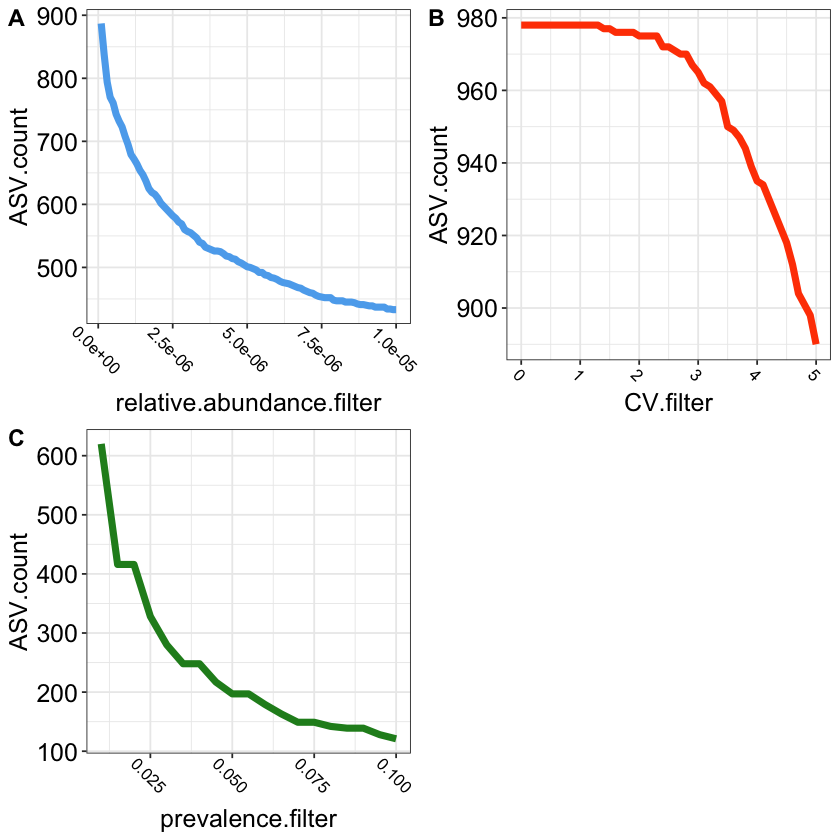

In [18]:
RA.stats <- as.threshold$relative.abundance.filtering.stats
CV.stats <- as.threshold$CV.filtering.stats
P.stats <- as.threshold$prevalence.filtering.stats
ASV.stats <- as.threshold$ASV.filtering.stats
ASV.stats.c <- ASV.stats[complete.cases(ASV.stats[,5]),] #remove filtered taxa


plot4 <- ggplot(data = RA.stats, aes(x = relative.abundance.filter, y = ASV.count)) + geom_line(size=2, color="steelblue2") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 10, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black"))

plot5 <- ggplot(data = CV.stats, aes(x = CV.filter, y = ASV.count)) + geom_line(size=2, color="orangered1") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 10, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black")) 

plot6 <- ggplot(data = P.stats, aes(x = prevalence.filter, y = ASV.count)) + geom_line(size=2, color="forestgreen") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 10, colour = "black", angle = 315, vjust = 0.7),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black")) 


plot_grid(plot4, plot5, plot6, labels = "AUTO")


Now that we've taken a peek at the effect of multiple thresholds and filters on the dataset read count, let's see how these filters will affect the taxonomic profile of our ASVs. For each plot, I've included a solid black line at the filter threshold that I'll apply in the next step. __Unfiltered taxa exist in the space above and right of the horizontal and vertical lines, respectively.__ <br>

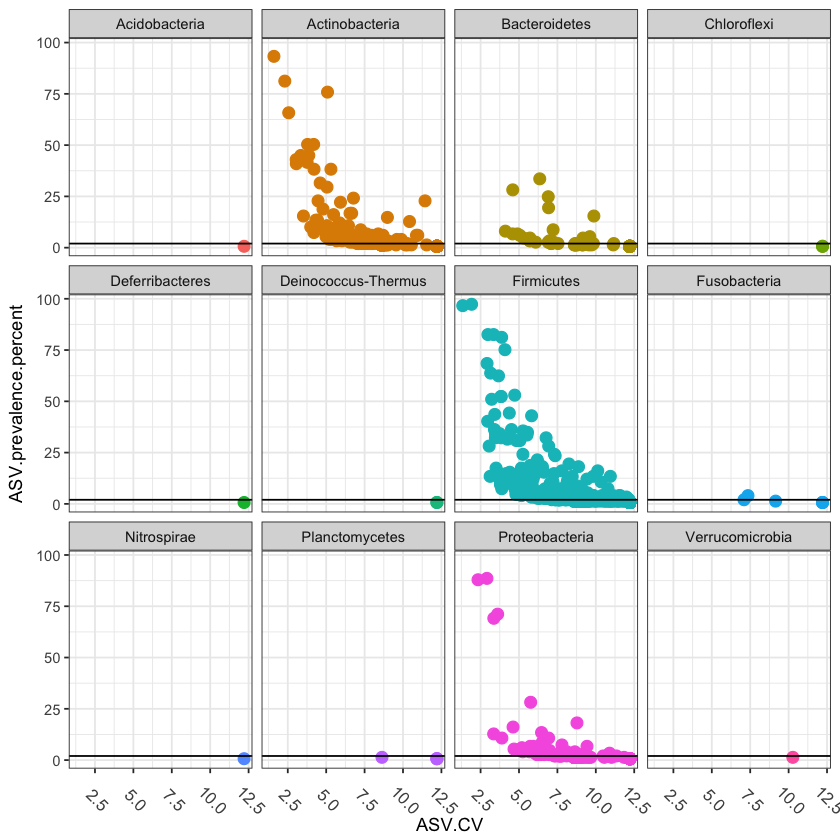

In [19]:
ggplot(data = ASV.stats.c, aes(x = ASV.CV, y = ASV.prevalence.percent, color=Phylum)) + geom_point(size=3) + 
  facet_wrap("Phylum", scales = "fixed") + 
  theme(axis.text.x = element_text(size = 10, angle = 315, vjust = 0.2), legend.position = "none") + 
geom_hline(yintercept = 2)


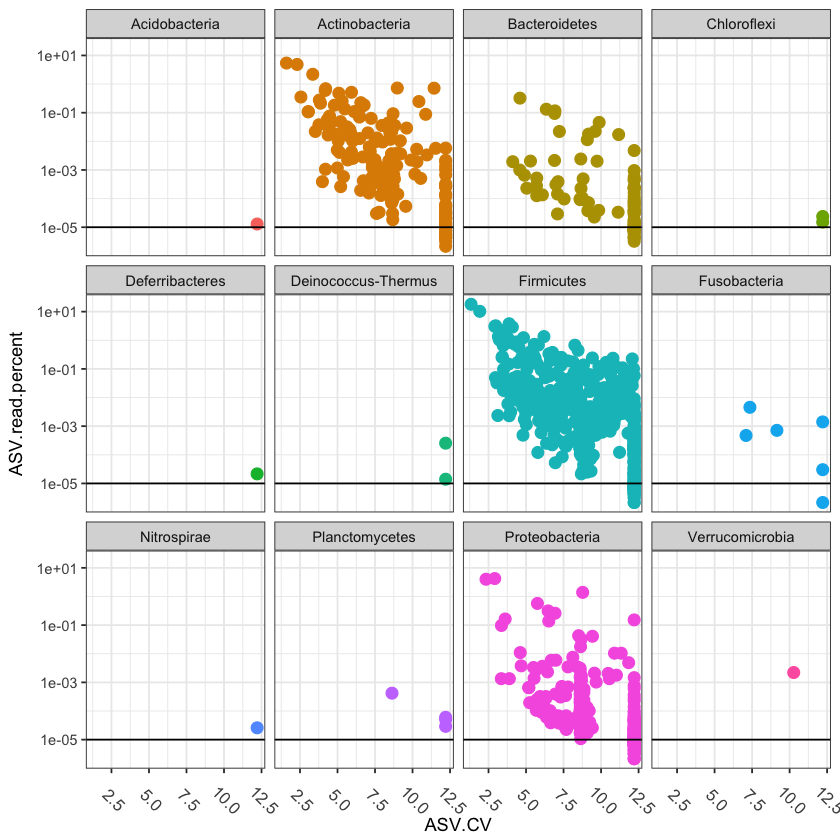

In [20]:
ggplot(data = ASV.stats.c, aes(x = ASV.CV, y = ASV.read.percent, color=Phylum)) + geom_point(size=3) + 
  facet_wrap("Phylum", scales = "fixed") + scale_y_log10() +
  theme(axis.text.x = element_text(size = 10, angle = 315, vjust = 0.2), legend.position = "none") + 
geom_hline(yintercept = 1e-5)


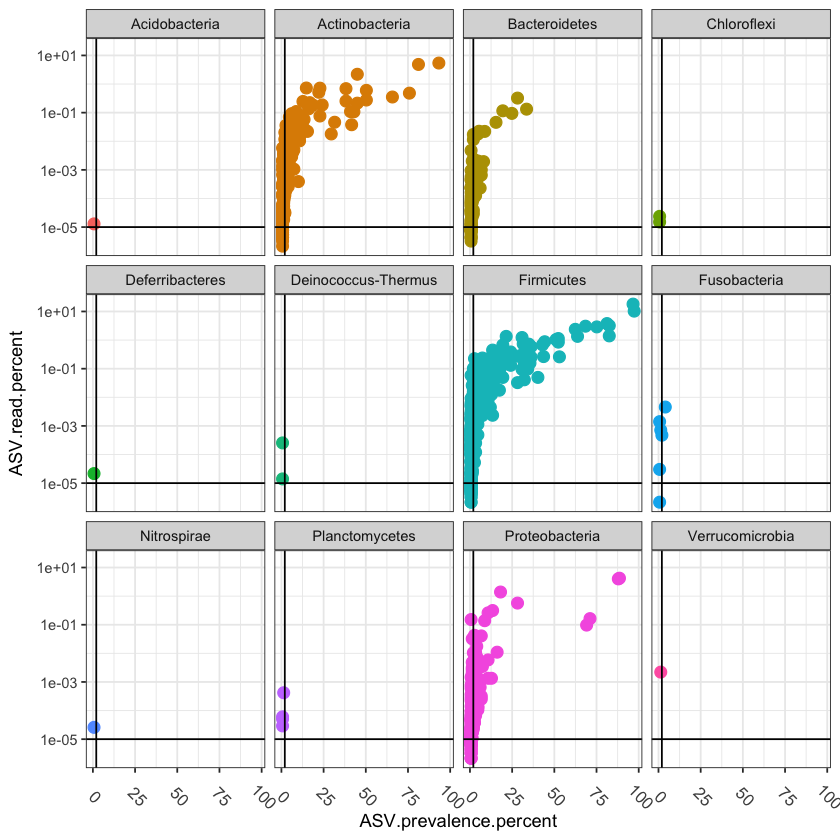

In [21]:
ggplot(data = ASV.stats.c, aes(x = ASV.prevalence.percent, y = ASV.read.percent, color=Phylum)) + geom_point(size=3) + 
  facet_wrap("Phylum", scales = "fixed") + scale_y_log10() +
  theme(axis.text.x = element_text(size = 10, angle = 315, vjust = 0.2), legend.position = "none") +
geom_hline(yintercept = 1e-5) + geom_vline(xintercept = 2) 


<div class="alert alert-block alert-warning">
<b>Commentary:</b> You might notice that I only chose to apply relative abundance and prevalence filters. 
While I think that all three have their associated merits, CV calculations and filters are particularly 
susceptible to compositional effects. <b>Prior to estimation and application of CV parameters, estimate.ASthreshold() normalizes each sample to the median sequencing depth of the dataset, but this still does not properly account 
for the compositional nature of marker gene studies.</b> <i>With that said, you should feel free to apply 
whatever approaches that you feel are appropriate!</i>
</div>

Now that we've estimated our WS and AS filtering parameters, we can apply these thresholds to our dataset with the __filter.dataset()__ function. __filter.dataset()__ is a multifaceted filtering funtion that first applies our previously estimated WS filter, removes samples below a read count threshold and/or that match a metadata indentifier, and then applies one or multiple AS filters.

<a id="filter.dataset"></a>
# filter.dataset
<div class="alert alert-block alert-info">
<b>FILTER.DATASET</b><br>
A highly flexible function that applies WS and AS (relative abundance, prevalence, CV), as well as metadata (positive and negative) and read count based filters. <br>
<br>
<b>Input:</b> <br>
<b>ps:</b> a phyloseq-class dataset.<br>
<br>
<b>Parameters (all are optional):</b><br>
<b>controlID:</b> As above, used only for reporting ASV read count, taxonomy, and sequence identity of taxa in the positive control.<br>
<b>mdCAT:</b> The sample data category used in conjunction with mdFACTOR for metadata based filtering.<br>
<b>mdFACTOR:</b> The factor within mdCAT used for metadata based filtering.<br>
<b>mdNEGATIVE:</b> A logical flag indicating whether metadata-based filtering should be positive (remove matching samples) or negative (remove non matching samples).<br>
<b>minLIB:</b> The minimum sequence depth for a sample to be retained.<br>
<b>RAT:</b> Relative Abundance Threshold; the percentage of reads across the dataset for which an ASV must be present for that ASV to be retained. <br>
<b>CVT:</b> Coefficient of Variation Threshold; the lowest CV value of an ASV for that ASV to be retained.<br>
<b>PFT:</b> Prevalence Filter Threshold; the percentage of samples across the dataset for which an ASV must be present for that ASV to be retained. <br>
<b>return.all:</b> A logical flag indicating whether to return all output or only the filtered dataset. Default is FALSE.<br>
<br><br>
<b>Output:</b> <br>
<b>control.taxa.sequences</b>
-  These are the nucleotide sequences of the taxa remaining in the positive control after applying the within-sample filter threshold. Useful for cross referenceing annotations against additional databases.<br>
<b>taxonomy.of.control.taxa</b>
-   The taxonomy of taxa in the positive control are output in the same order as the sequences, above. Generally useful for validating that the bugs detected in your mock community are as intended. <br>
<b>read.count.table</b>
-  This table lists the read count and percentage remaining after each filtering step. Samples matching given metadata identifiers are removed after application of the WS filter and prior to the AS filter(s) and, as such, will list NA values for AS filter statistics.  <br>
<b>relative abundance.filter.threshold</b>
-  The read count corresponding to the percentage given to the RAT parameter. <br>
<b>prevalence.filter.threshold</b>
-  The sample count corresponding to the percentage given to the PFT parameter. <br>
<b>filtered.phyloseq</b>
-  the shiny new (phyloseq class) filtered dataset with control samples removed. <br>

</div>


In [22]:
NI.f <- filter.dataset(ps = NI, controlID = "pc1", mdCAT = "timepoint", 
                      mdFACTOR = "control", WST = 1.4e-4, PFT = 0.02, RAT = 1e-5, minLIB = 4000, return.all = TRUE)

Removing 13 samples with read count < 4000
Applying WS filter threshold of 0.00014
Removing 6 samples matching metadata identifiers timepoint:control
Applying relative abundance threshold of 1e-05
Applying prevalence threshold of 0.02


In [23]:
NI.f$ntaxa.in.control

[1] 25

In [24]:
NI.f$control.taxa.sequences

[1] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCCGATGCTATTTCTAGAGATAGGAAGTTACTTCGGTACATCGGTGACAGG"
 [2] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACAGAACTTTCCAGAGATGGATTGGTGCCTTCGGGAACTGTGAGACAGG"
 [3] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACGGAAGTTTTCAGAGATGAGAATGTGCCTTCGGGAACCGTGAGACAGG"
 [4] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTTTGACAACTCTAGAGATAGAGCCTTCCCCTTCGGGGGACAAAGTGACA"
 [5] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTTTGACCACTCTAGAGATAGAGCTTTCCCTTCGGGGACAAAGTGACAGG"
 [6] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTCTGACCCCTCTAGAGATAGAGTTTTCCCCTTCGGGGGACAGAGTGACA"
 [7] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTTTGACAACTCTAGAGATAGAGCTTTCCCCTTCGGGGGACAAAGTGACA"
 [8] "GGGCCCGCACAAGCGGCGGAGCATGCGGATTAATTCGATGCAACGCGAAGAACCTTACCAAGGCTTGACATGCACGGCGGCACTGCAGAGATGTGGTGGCATTTAGTTGGTCGTGTGCAGGT"
 [9] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCCTCTGACCGCTCTAGAGATAGAGCTTTCCTTCGGGACAGAGGTGACAGG"
[10] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCCGATGCTATTCTTAGAGATAGGAAGTTACTTCGGTACATCGGAGACAGG"
[11] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGCCTTGACATCCAATGAACTTTCTAGAGATAGATTGGTGCCTTCGGGAACATTGAGACAGG"
[12] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGCAGAACCTTACCAACCCTTGACATGGCGATCGCGGTTCCAGAGATGGTTCCTTCAGTTCGGCTGGATCGCACACA"
[13] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTTCTGACCGGCCTAGAGATAGGCTTTCTCTTCGGAGCAGAAGTGACAGG"
[14] "GGGCCCGCACAAGCGGAGGAACATGTGGTTTAATTCGATGATACGCGAGGAACCTTACCCGGGCTTAAATTGCAGATGAATTACGGTGAAAGCCGTAAGCCGCAAGGCATCTGTGAAGGTGC"
[15] "GGACCCGCACAAGCGGTGGATGATGTGGATTAATTCGATGCAACGCGAAAAACCTTACCTACCCTTGACATGTCTGGAATGCCGAAGAGATTTGGTAGTGCTCGCAAGAGAACCGGAACACA"
[16] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCAGTGCAAACCTAAGAGATTAGGTGTTCCCTTCGGGGACGCTGAGACAGG"
[17] "GGCCCCGCACAAGCGGCGGAGCATGCGGATTAATTCGATGCAACGCGTAGAACCTTACCTGGGTTTGACATGGATCGGGAGTGCTCAGAGATGGGTGTGCCTCTTTTGGGGTCGGTTCACAG"
[18] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTCTGATCCCTCTAGAGATAGAGGTTTCCCCTTCGGGGGACAGAGTGACA"
[19] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTCTGACAACCCTAGAGATAGGGCTTCTCCTTCGGGAGCAGAGTGACAGG"
[20] "GGGCCCGCACAAGCAGCGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCTAGACTTGACATCTCCTGAATTACCCTTAATCGGGGAAGCCCTTCGGGGCAGGAAGACAGGTG"
[21] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCTGGCCTTGACATGCTGAGAACTTTCCAGAGATGGATTGGTGCCTTCGGGAACTCAGACACAGG"
[22] "GGACCCGCACAAGCGGTGGATGATGTGGATTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATGTACGGAATCCTCCGGAGACGGAGGAGTGCCTTCGGGAGCCGTAACACAGG"
[23] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTTTGACCACTCTGGAGACAGAGCTTTCCCTTCGGGGACAAAGTGACAGG"
[24] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGCCTTGACATACTAGAAACTTTCCAGAGATGGATTGGTGCCTTCGGGAATCTAGATACAGG"
[25] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATGCTAGGAACTTTGCAGAGATGCAGAGGTGCCCTTCGGGGAACCTAGACACA"

In [25]:
NI.f$taxonomy.of.control.taxa

Kingdom,Phylum,Class,Order,Family,Genus,Species
Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,lactarius/salivarius
Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Salmonella,NA
Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia/Shigella,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,lingnae/odontolyticus/turicensis
Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,NA
Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,mutans


In [26]:
NI.f$read.count.table[135:149, ]

,unfiltered.read.count,WSfiltered.read.count,WSfiltered.read.percent,ASfiltered.read.count,ASfiltered.read.percent
N.0395..Week.36,1256538,1252944,99.71398,1212704,96.51153
N.0395..Week.4,523876,522239,99.68752,521647,99.57452
N.0704..baseline,71953,71268,99.04799,69124,96.06827
N.0704..Week.15,782531,780733,99.77023,779930,99.66762
N.0704..Week.36,886216,883769,99.72388,874150,98.63848
N.0704..Week.4,177996,176089,98.92863,173717,97.59601
N.0705..baseline,888231,885186,99.65718,866188,97.51833
N.0705..Week.15,1193231,1188586,99.61072,1188139,99.57326
N.0705..Week.4,951118,947463,99.61572,947129,99.58060
nc1,111821,110452,98.77572,NA,NA


In [27]:
NI.f$relative.abundance.filter.read.count

[1] 915.1099

In [28]:
NI.f$prevalence.filter.sample.count

[1] 2.86

In [29]:
(NIF <- NI.f$filtered.phyloseq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 344 taxa and 143 samples ]
sample_data() Sample Data:       [ 143 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 344 taxa by 7 taxonomic ranks ]

## Processing and exporting
<br>Now that we've filtered the dataset to our liking, we'll export all of the data associated with our final, filtered dataset using the __write.dataset()__ function. Unfortunately, I've never been able to get the biomformat package (v1.2.0) to play nice with my version of phyloseq, but y'all may have more luck with newer versions. In case the kinks have been worked out, I'd recommend using the __write.dataset.biom()__ function to export your dataset directly to biom format. Until then, we'll use __write.dataset()__ to perform some final minor modifications and export our dataset. 

<a id="write.dataset"></a>
# write.dataset, write.dataset.biom
<div class="alert alert-block alert-info">
<b>WRITE.DATASET, WRITE.DATASET.BIOM</b><br>
Exporting functions for writing marker gene datasets to external files.<br>
<br>
<b>Input:</b> <br>
<b>ps:</b> a phyloseq-class dataset.<br>
<br>
<b>Parameters:</b><br>
<b>Filepath:</b> The filepath where output should be written.<br>
<b>Fileprefix:</b> The prefix identifier for all output written.<br>
<b>Rename:</b> A logical flag indicating if ASV identifiers should be renamed to ASV1, ASV2, ..., ASVN. Default is FALSE.<br>
<br>
<b>Output:</b> <br>
<b>_ASVs.fasta:</b>  FASTA of all ASV sequences. Even if rename=FALSE, FASTA identifiers are labeled ASV1, ASV2,... <br>
<br>
<b>write.dataset.biom:</b><br>
<b>_ASV_table.biom:</b> A biom file with observation and sample metadata integrated. I've run into problems attempting to import the resulting biom back into phyloseq, but this might warrant a closer look with a newer version. <br>
<br>
<b>write.dataset:</b><br>
<b>_ASV_table.txt:</b>  A standard count table (eg. OTU table) of read counts of taxa (ASVs) across all samples. <br>
<b>_ASV_taxonomy.txt:</b> A taxonomy table with the sequence identifier (eg. ASV1) in the first column and semicolon-separated taxonomy in the second column.<br>
<b>_sample_data.txt:</b> A sample data table of all associated metadata. 
<br>

</div>
<br>
<div class="alert alert-block alert-success">
<b>TIP:</b> Before writing, all files written by <b>write.dataset()</b> are formatted for easy merging into a biom file using the  <A HREF = "http://biom-format.org/documentation/biom_conversion.html">standalone biom package</A> without any further manipulation. 
</div>

In [30]:
fp <- paste(getwd(), "/", sep = "")
NIF.f <- write.dataset(ps = NIF, filepath = fp, fileprefix = "Nif.f", rename = TRUE)

[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/marker_gene_processing_vignette/Nif.f_ASVs.fasta"
[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/marker_gene_processing_vignette/Nif.f_ASV_table.txt"
[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/marker_gene_processing_vignette/Nif.f_ASV_taxonomy.txt"
[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/marker_gene_processing_vignette/Nif.f_sample_data.txt"


Boom! We've now written all of the metadata associated with our filtered marker gene study to various output files. Now, let's take a final peek at our ASV count table in a format that's a little more friendly on the eyes. 

In [31]:
phyloseq::otu_table(NIF.f)[1:10, 1:10]

,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10
N.0055..baseline,0,57092,0,0,0,0,532461,8519,0,55386
N.0055..Week.15,3137,50,126,170,12,16,59,26,27,0
N.0055..Week.36,1745,583068,295,7571,0,117,0,225,161094,0
N.0055..Week.4,1552,4311,24642,3267,422,0,86,104530,0,1295
N.0170..baseline,1438,368,362,772,431,392,1023,361,265,1382
N.0170.Week.15,136177,269,99767,0,642,505,1201,72,3606,91
N.0170.Week.36,367401,8053,17969,0,40399,31963,271,0,50041,752
N.0170.Week.4,335868,788,77043,0,11923,6800,1818,42446,4513,0
N.0183..baseline,12981,5611,44012,1452,1553,1915,1577,1821,231,2531
N.0183.Week.15,58948,97,23709,24,111,0,0,56,2227,0


Finally, let's subset our filtered dataset to include only samples that were collected during the first week of the study. We can enable negative metadata filtering with the flag mdNEGATIVE.

In [32]:
NIF.fw1 <- filter.dataset(ps = NIF.f, mdCAT = "timepoint", mdFACTOR = "Week 1", mdNEGATIVE = TRUE, return.all = FALSE)

Removing 111 samples not matching metadata identifiers timepoint:Week 1


In [33]:
NIF.fw1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 344 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 344 taxa by 7 taxonomic ranks ]